In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import plotly.express as px
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
import category_encoders as ce
from sklearn.preprocessing import FunctionTransformer

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

# Hotel Customer Analytic : canceled booking

### Created By : Ridlo Setiadeswan

# Business Problem Understanding

**Context**

sebuah perusahaan hotel di portugal ingin menganalisa penyebab pelanggan yang melakukan pembatalan pemesanan. juga ingin untuk mengetahui pelanggan mana yang tepat dan tidak akan mengcancel.

Target :

0 : Pelanggan tetap melakukan Booking

1 : pelanggan cancel

**Problem Statement :**

pemesanan kamar yang berakhir di *cancel* akan membuat hotel merugi karena akan membuat kamar kosong dan tidak jadi memberikan *untung* kepada Hotel.
Hotel ingin meningkatkan efisiensi penyaringan pelanggan dengan mengetahui pelanggan seperti apa yang memiliki kecenderungan akan membatalkan pemesanan.

**Goals :**

Maka berdasarkan permasalahan tersebut, Hotel ingin memiliki kemampuan untuk memprediksi kemungkinan pelanggan yang akan menginap/tidak, sehingga  dapat memfokuskan para customer yang akan menginap. dan juga, hotel ingin mengetahui faktor apa yang membuat seorang customer akan menginap/membatalkan pemesanannya. sehingga dapat membuat rencana yang lebih baik dalam mendekati pelanggan potensial

**Analytic Approach :**

Jadi yang akan saya lakukan adalah menganalisis data untuk menemukan pola yang membedakan pelanggan yang mau menginap dan yang tidak mau kemudian akan dibuatkan model klasifikasi yang akan membantu Hotel dalam memprediksi probabilitas pelanggan yang akan menginap atau tidak.

**Metric Evaluation :**




Type 1 error : False Positive  (prediksi cancel realnya menginap)
Konsekuensi: engagement dengan customer menurun karena customer yang akan menginap di prediksi cancel, namun sebenarnya tidak

Type 2 error : False Negative  (prediksi menginap realnya cancel)
Konsekuensi: keuntungan penyewaan kamar menurun karena kamar tidak jadi di sewa. 

Berdasarkan konsekuensinya, dibuatkan model yang dapat mengurangi kesalahan dalam memprediksi pelanggan cancel yang terdeteksi menjadi pelanggan tidak cancel. tanpa mengurangi engagement dengan customer yang memang akan menginap. menggunakan sesedikit mungkin false negative. jadi metric evaluation Utama yang akan saya gunakan adalah Roc auc. karena nilai ROC AUC menunjukan seberapa bisa model membedakan antara class positive dan negatif

# Data Understanding 

Note : 
- Dataset tidak seimbang
- terdapat 10 fitur dengan komposisi 5 fitur kategorikan dan 5 fitur Nominal. beberapa fitur dengan kardinalitas tinggi
- Setiap baris data merepresentasikan informasi seorang customer yang sudah/ tidak jadi menginap pada sebuah hotel di portugal

In [2]:
#Load Dataset
df = pd.read_csv("data_hotel_booking_demand.csv")
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [4]:
display(df.describe(), df.describe(include='object'))

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


# Data Cleaning

data yang hilang, kesalahan input pada data, tidak bisa di cek duplikat karena tidak ada id yang membedakan antara 1 data dengan lainya maka semua data dianggap unik.

In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[MDV, IND]"
1,market_segment,object,0,0.00,8,"[Online TA, Aviation]"
2,previous_cancellations,int64,0,0.00,15,"[0, 11]"
3,booking_changes,int64,0,0.00,19,"[4, 9]"
4,deposit_type,object,0,0.00,3,"[Refundable, No Deposit]"
5,days_in_waiting_list,int64,0,0.00,115,"[174, 100]"
6,customer_type,object,0,0.00,4,"[Group, Transient]"
7,reserved_room_type,object,0,0.00,10,"[B, C]"
8,required_car_parking_spaces,int64,0,0.00,5,"[8, 2]"
9,total_of_special_requests,int64,0,0.00,6,"[2, 4]"


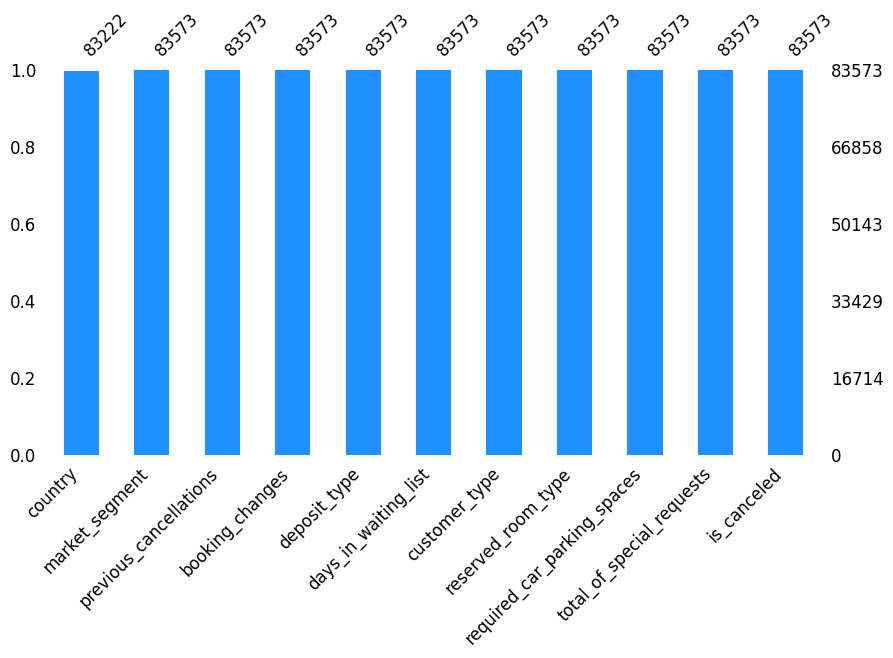

In [6]:
missingno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [7]:
df['country'].unique()

array(['IRL', 'FRA', 'PRT', 'NLD', 'ESP', 'UMI', 'CN', 'LUX', 'BRA',
       'BEL', 'JPN', 'DEU', 'ITA', 'CHE', 'GBR', 'AGO', 'SRB', 'COL',
       'CHN', 'SWE', 'AUT', 'CIV', 'CZE', 'POL', 'USA', 'SGP', 'RUS',
       'ROU', 'DNK', 'IND', 'MAR', 'PHL', 'ARG', 'ISL', 'ZAF', 'LBN',
       'MOZ', 'TUR', 'BGD', 'MEX', 'CAF', 'NOR', 'FIN', 'UKR', 'EGY',
       'ISR', nan, 'KOR', 'AZE', 'HUN', 'AUS', 'EST', 'CHL', 'SVN', 'PRY',
       'ABW', 'ALB', 'LTU', 'ARE', 'HRV', 'SAU', 'NZL', 'LVA', 'ATA',
       'KAZ', 'DZA', 'TWN', 'CRI', 'BIH', 'BGR', 'IRQ', 'OMN', 'VEN',
       'IDN', 'GEO', 'MLT', 'IRN', 'BLR', 'URY', 'LBY', 'TUN', 'BEN',
       'MYS', 'MWI', 'GRC', 'CYP', 'CPV', 'HKG', 'PRI', 'MKD', 'MUS',
       'IMN', 'PAN', 'NGA', 'GLP', 'KHM', 'PER', 'QAT', 'SEN', 'MAC',
       'SVK', 'BHR', 'ECU', 'SYC', 'BOL', 'TJK', 'LCA', 'MDV', 'SYR',
       'ZMB', 'LIE', 'THA', 'MNE', 'BRB', 'CMR', 'JEY', 'GTM', 'LKA',
       'JOR', 'TZA', 'AND', 'ARM', 'GIB', 'VNM', 'PAK', 'JAM', 'DOM',
       'KWT', 'L

In [8]:
Country_counts = df['country'].value_counts()


# Print the percentage of each value
print(Country_counts)

PRT    34097
GBR     8495
FRA     7307
ESP     5996
DEU     5116
       ...  
ZMB        1
LCA        1
SYC        1
GLP        1
AIA        1
Name: country, Length: 162, dtype: int64


In [9]:
Country_counts = df['country'].value_counts()
Country_counts_percent = Country_counts / Country_counts.sum() * 100

# Print the percentage of each value
print(Country_counts_percent)

PRT    40.971137
GBR    10.207637
FRA     8.780130
ESP     7.204826
DEU     6.147413
         ...    
ZMB     0.001202
LCA     0.001202
SYC     0.001202
GLP     0.001202
AIA     0.001202
Name: country, Length: 162, dtype: float64


In [10]:
df['country'].fillna('PRT', inplace=True)


pembuatan persentase diatas dikarenakan saya hendak mengisi data null dengan data terbanyak. yang didasari :

1. apabila dia datang dari negara portugal/ ditempat hotel tersebut berada maka ada asumsi dimana pelanggan akan cenderung tidak mengisi, ini berdasarkan pengalaman pribadi saya..

2. jika dilihat dari persentase data diatas dapat dilihat bahwa 40 persen data pelanggan yang datang adalah pelanggan yang berasal dari portugal.

maka dari itu saya akan mengisi data null tersebut dengan PRT(portugal)
dengan asumsi pengisian data ini tidak akan mengubah kecenderungan data secara signifikan.

In [11]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,0,0.0,162,"[PLW, GIB]"
1,market_segment,object,0,0.0,8,"[Groups, Complementary]"
2,previous_cancellations,int64,0,0.0,15,"[0, 26]"
3,booking_changes,int64,0,0.0,19,"[10, 1]"
4,deposit_type,object,0,0.0,3,"[No Deposit, Non Refund]"
5,days_in_waiting_list,int64,0,0.0,115,"[5, 87]"
6,customer_type,object,0,0.0,4,"[Transient-Party, Contract]"
7,reserved_room_type,object,0,0.0,10,"[H, D]"
8,required_car_parking_spaces,int64,0,0.0,5,"[3, 0]"
9,total_of_special_requests,int64,0,0.0,6,"[4, 2]"


In [12]:
df.describe(include=['O'])

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83573,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34448,39460,73352,62732,60041


In [13]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


# remove unused data

saya akan hapus kolom Country dari dataset saya, dimana alasan kolom Country dihapus adalah untuk supaya analisa yang saya lakukan dan juga model ML yang nanti saya akan buat, tidak melakukan diskriminasi terhadap Country. 

Dimana semestinya, Country tidak mempengaruhi/membedakan mana pelanggan yang akan meng cancel dan tidak. 

In [14]:
for i in ['country']:
    fig=px.sunburst(df,path=[i,'is_canceled'],color='is_canceled', title=f'Proporsi negara pemesan {i}')
    fig.show()


karena jika dilihat dari grafik pun bahwa data negara ini didominansi dengan data dari negara portugal saja dengan nilai 40% dari total keseluruhan data sedangkan data kedua terbesar hanya 10% dari keseluruhan data. selain tidak cocok untuk machine learning  juga tidak cocok untuk dianalisa karena data yang tidak seimbang juga karena beberapa data di tutupi oleh anonimity reason sehingga semakin sulit mencari korelasi antara country dengan fitur lain.

In [15]:
df.drop('country', axis=1, inplace= True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   market_segment               83573 non-null  object
 1   previous_cancellations       83573 non-null  int64 
 2   booking_changes              83573 non-null  int64 
 3   deposit_type                 83573 non-null  object
 4   days_in_waiting_list         83573 non-null  int64 
 5   customer_type                83573 non-null  object
 6   reserved_room_type           83573 non-null  object
 7   required_car_parking_spaces  83573 non-null  int64 
 8   total_of_special_requests    83573 non-null  int64 
 9   is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 6.4+ MB


In [17]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [18]:
df.dropna().describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [19]:
df.dropna().describe(include= 'O')

,market_segment,deposit_type,customer_type,reserved_room_type
count,83573,83573,83573,83573
unique,8,3,4,10
top,Online TA,No Deposit,Transient,A
freq,39460,73352,62732,60041


In [20]:
df.describe(include= 'O')

,market_segment,deposit_type,customer_type,reserved_room_type
count,83573,83573,83573,83573
unique,8,3,4,10
top,Online TA,No Deposit,Transient,A
freq,39460,73352,62732,60041


In [21]:
df['is_canceled'].value_counts()

0    52795
1    30778
Name: is_canceled, dtype: int64

In [22]:
df['is_canceled'].value_counts(normalize= True)

0    0.631723
1    0.368277
Name: is_canceled, dtype: float64

In [23]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,market_segment,object,0,0.0,8,"[Offline TA/TO, Aviation]"
1,previous_cancellations,int64,0,0.0,15,"[14, 4]"
2,booking_changes,int64,0,0.0,19,"[20, 0]"
3,deposit_type,object,0,0.0,3,"[No Deposit, Non Refund]"
4,days_in_waiting_list,int64,0,0.0,115,"[108, 60]"
5,customer_type,object,0,0.0,4,"[Contract, Transient-Party]"
6,reserved_room_type,object,0,0.0,10,"[F, C]"
7,required_car_parking_spaces,int64,0,0.0,5,"[0, 8]"
8,total_of_special_requests,int64,0,0.0,6,"[3, 5]"
9,is_canceled,int64,0,0.0,2,"[1, 0]"


# Data Analysis

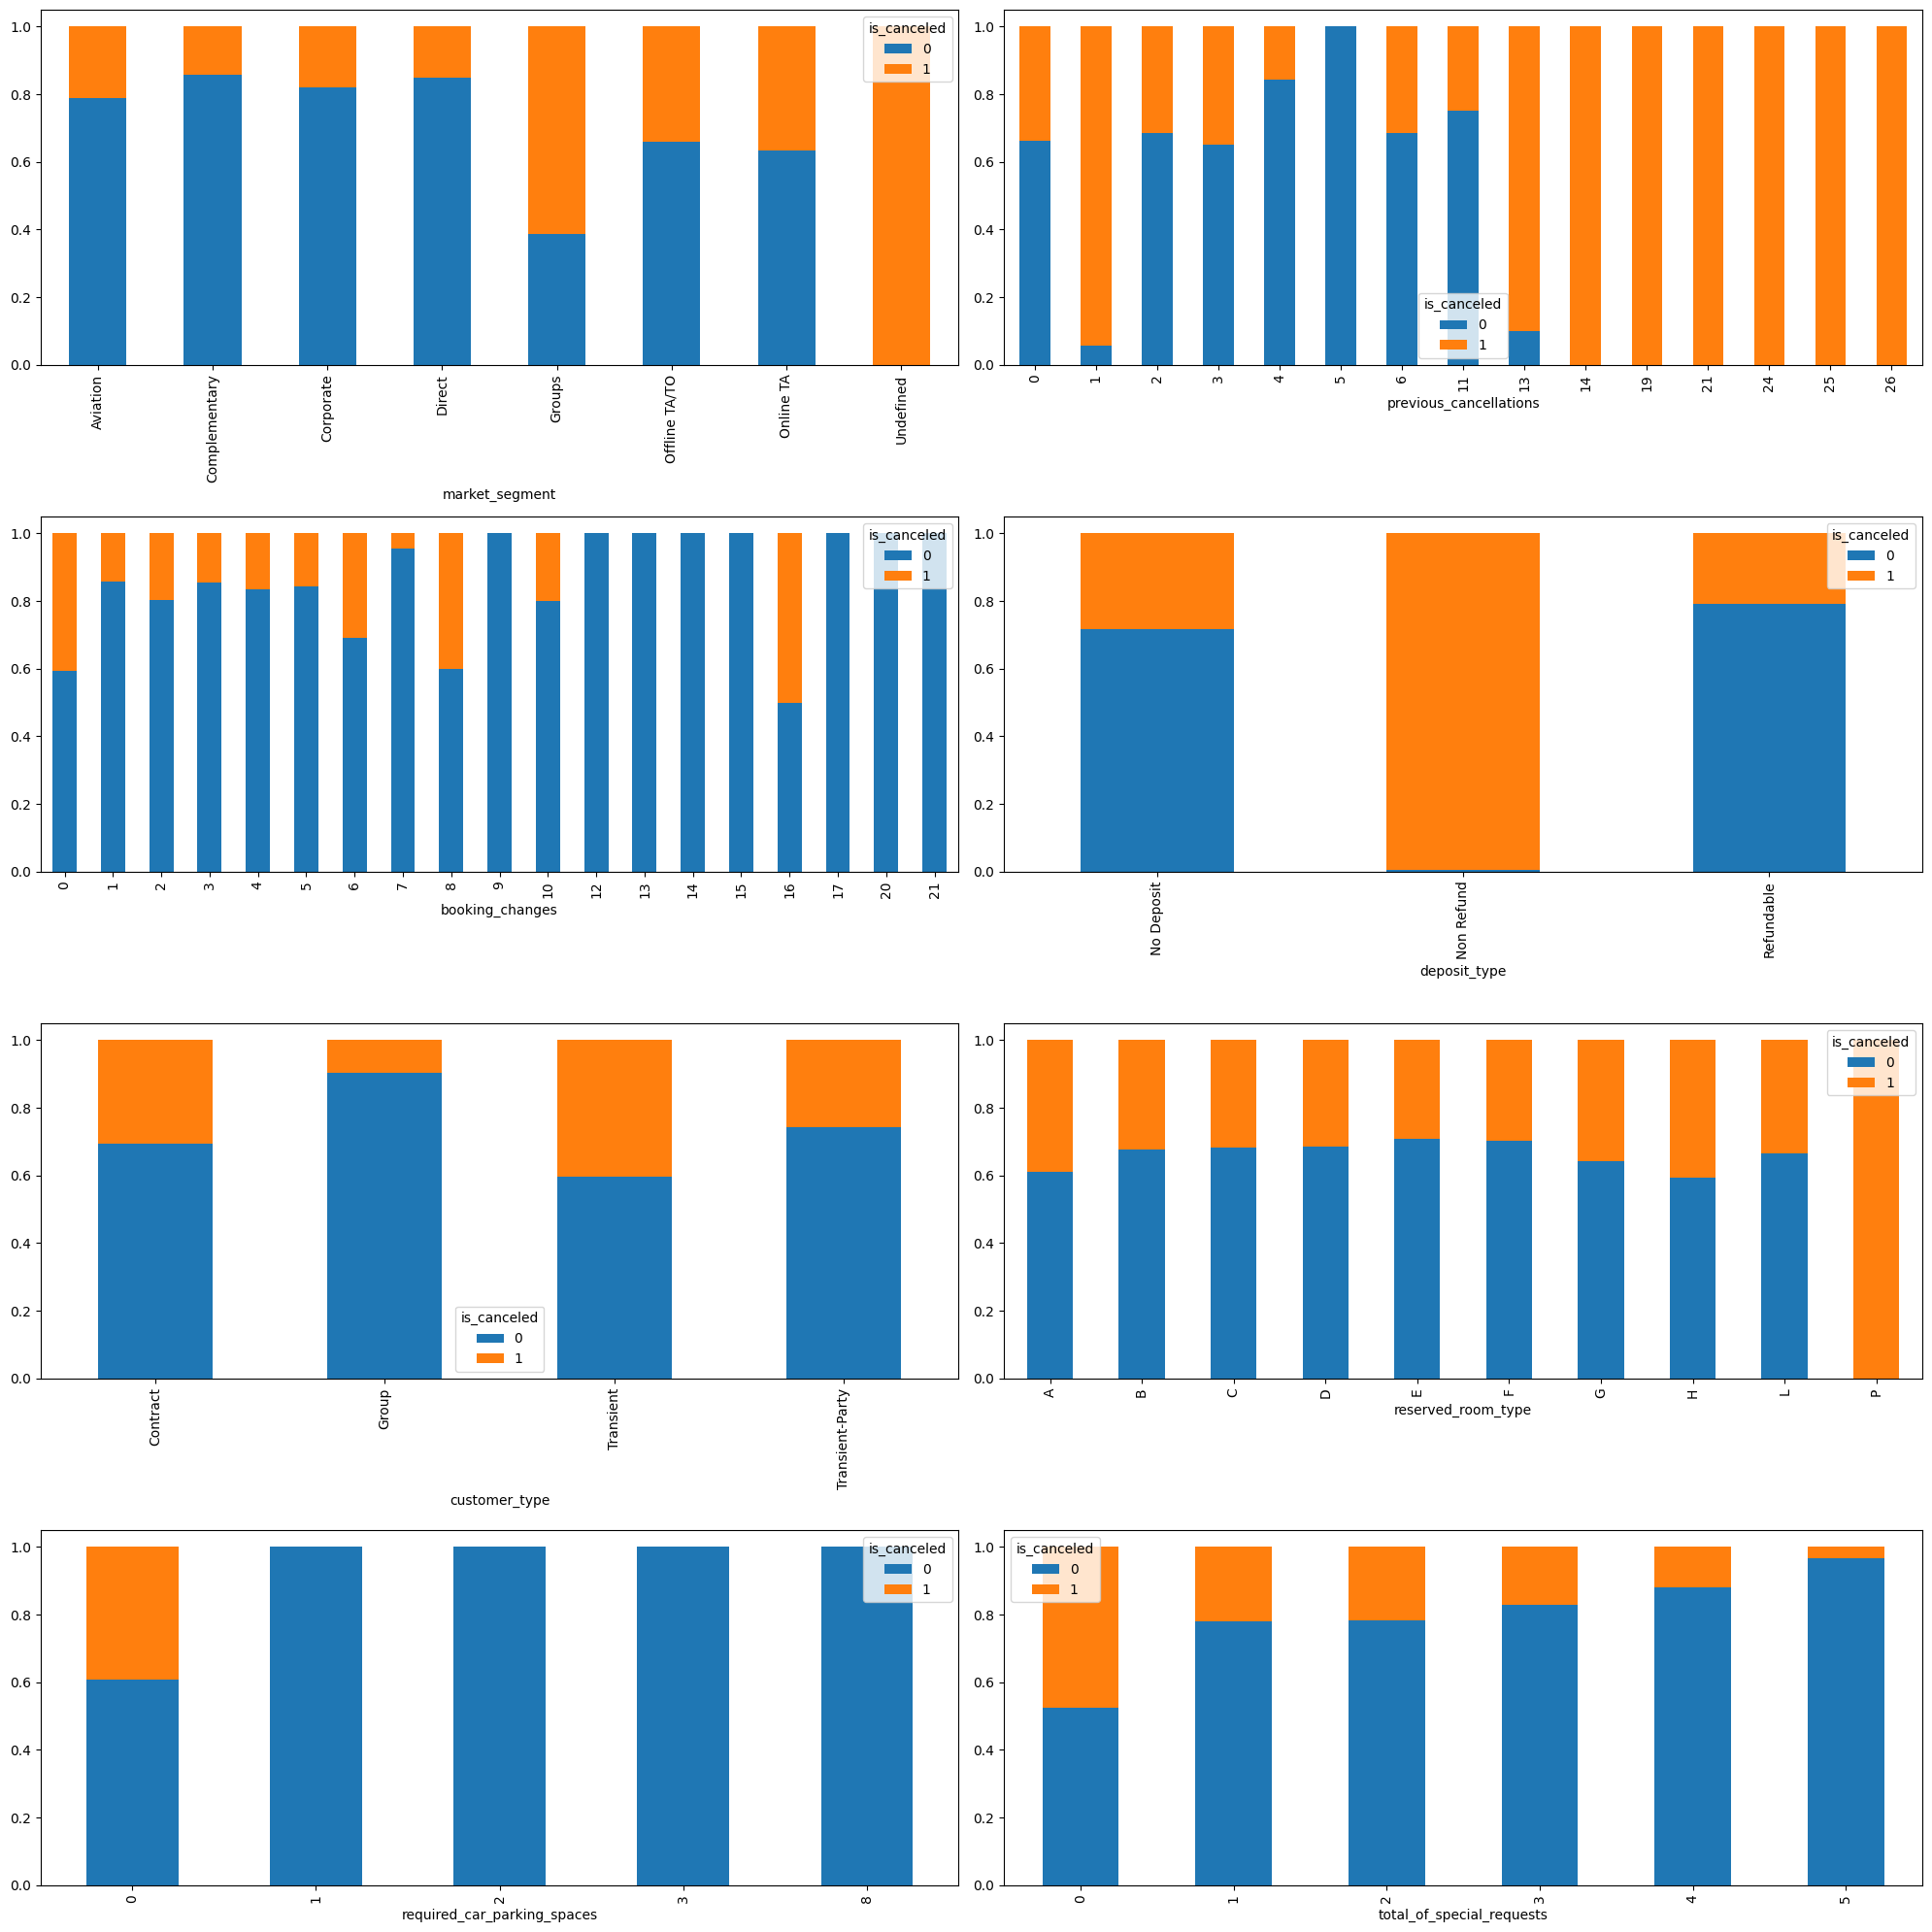

In [24]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['is_canceled','days_in_waiting_list']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

In [25]:
for i in df.drop(columns=['is_canceled']).columns:
    abc = df.groupby(i)['is_canceled'].value_counts(normalize=True).unstack()
    abc['count'] = df.groupby(i)['is_canceled'].count()
    display(abc.sort_values(by=[1.0], ascending=False))

is_canceled,0,1,count
market_segment,,,
Undefined,NaN,1.000000,1
Groups,0.386925,0.613075,13721
Online TA,0.634237,0.365763,39460
Offline TA/TO,0.659853,0.340147,17025
Aviation,0.787879,0.212121,165
Corporate,0.819093,0.180907,3792
Direct,0.848618,0.151382,8898
Complementary,0.857143,0.142857,511


is_canceled,0,1,count
previous_cancellations,,,
14,NaN,1.000000,10
19,NaN,1.000000,12
21,NaN,1.000000,1
24,NaN,1.000000,33
25,NaN,1.000000,17
26,NaN,1.000000,18
1,0.056572,0.943428,4207
13,0.100000,0.900000,10
3,0.652174,0.347826,46


is_canceled,0,1,count
booking_changes,,,
16,0.500000,0.500000,2
0,0.593639,0.406361,70873
8,0.600000,0.400000,10
6,0.692308,0.307692,39
10,0.800000,0.200000,5
2,0.802790,0.197210,2652
4,0.834615,0.165385,260
5,0.844444,0.155556,90
3,0.856025,0.143975,639


is_canceled,0,1,count
deposit_type,,,
Non Refund,0.006231,0.993769,10111
No Deposit,0.717704,0.282296,73352
Refundable,0.790909,0.209091,110


is_canceled,0,1,count
days_in_waiting_list,,,
391,NaN,1.0,33
71,NaN,1.0,10
79,NaN,1.0,14
26,NaN,1.0,3
76,NaN,1.0,2
...,...,...,...
121,1.0,NaN,1
150,1.0,NaN,7
185,1.0,NaN,1


is_canceled,0,1,count
customer_type,,,
Transient,0.595645,0.404355,62732
Contract,0.692922,0.307078,2882
Transient-Party,0.744183,0.255817,17536
Group,0.903073,0.096927,423


is_canceled,0,1,count
reserved_room_type,,,
P,NaN,1.000000,9
H,0.593516,0.406484,401
A,0.610400,0.389600,60041
G,0.641327,0.358673,1447
L,0.666667,0.333333,3
B,0.675985,0.324015,787
C,0.683507,0.316493,673
D,0.684386,0.315614,13526
F,0.702504,0.297496,2037


is_canceled,0,1,count
required_car_parking_spaces,,,
0,0.607153,0.392847,78346
1,1.000000,NaN,5202
2,1.000000,NaN,22
3,1.000000,NaN,1
8,1.000000,NaN,2


is_canceled,0,1,count
total_of_special_requests,,,
0,0.524904,0.475096,49188
1,0.780047,0.219953,23214
2,0.784320,0.215680,9120
3,0.827915,0.172085,1784
4,0.881356,0.118644,236
5,0.967742,0.032258,31


is_canceled,0,1
days_in_waiting_list,,
0,51871,29117
1,5,2
2,2,0
3,0,41
4,14,6
...,...,...
236,20,3
259,8,0
330,8,0


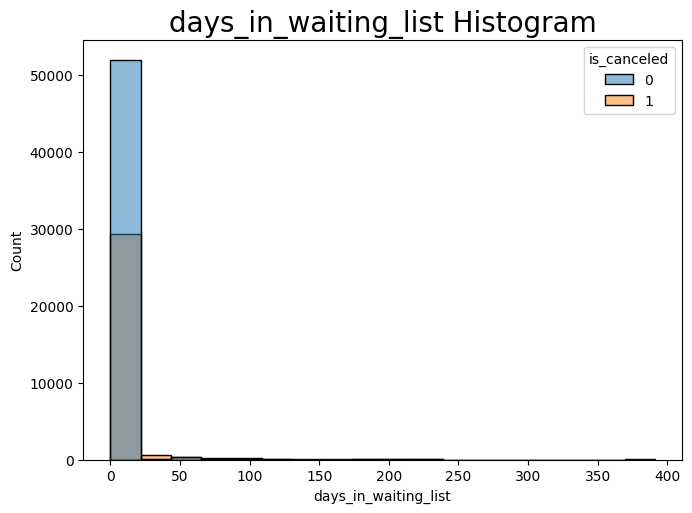

In [26]:
plt.figure(figsize=(17,12))

plt.subplot(222)
sns.histplot(data=df,x='days_in_waiting_list',hue='is_canceled',kde=False)
plt.title('days_in_waiting_list Histogram',fontsize=20)

pd.crosstab(df['days_in_waiting_list'], df['is_canceled'])


In [27]:
pd.crosstab([df['reserved_room_type'], df['required_car_parking_spaces']], df['is_canceled'])

is_canceled                                         0      1
reserved_room_type required_car_parking_spaces              
A                  0                            33907  23392
                   1                             2730      0
                   2                               11      0
                   3                                1      0
B                  0                              501    255
                   1                               31      0
C                  0                              334    213
                   1                              126      0
D                  0                             8309   4269
                   1                              945      0
                   2                                3      0
E                  0                             2606   1351
                   1                              688      0
                   2                                2      0
                   8                                2      0
F                  0                             1149    606
                   1                              280      0
                   2                                2      0
G                  0                              627    519
                   1                              298      0
                   2                                3      0
H                  0                              133    163
                   1                              104      0
                   2                                1      0
L                  0                                2      1
P                  0                                0      9

Berdasarkan barplot dan table diatas dapat menyimpulkan beberapa hal :

1. pada `Market_segment` hanya Group dan undefined yang memilik presentasi pembatalan lebih besar dibandingkan pemesanan. hal ini dapat terjadi karena ketika group membatalkan pemesanan dapat mewakili lebih dari 1 kamar yang dibatalkan maka anggap 1 group 8 orang maka akan memesan 4 kamar, dalam data ini maka 4 kamar adalah sama dengan 4 data. ketika group memutuskan untuk pembatalan maka akan 4 data `is_canceled` baru dalam data set ini. dan untuk `undefined` sebenarnya data ini bisa dihapus karena hanya 1 data saja tanpa ada data lain. namun dikarenakan data tersebut adala data pembaqtalan jadi saya tetap masukan agar menjadi faktor baru karena dari kategor di `market segment` ini sudah cukup mewakili namnun masih tetap ada `undefined` sehingga data tetap disimpan agar menjadi pembelajaran untuk model. kategori dengan persentase not_canceled terbanyak ada oada kategori complementary yang dimana ini seharunya bisa 100% tidak di canceled selain alasan 'force majeure', maka saya merekomendasi hotel untuk melihat mengapa dapat terjadinya canceled dengan membuat data khusus untuk `market segment` tersebeut agar tepat rekomendasi yang harus diberikan/aksi yang harus dilakukan agar pelanggan tidakl melakukan cancel.  
2. `previous_booking_cancellation`, pada data ini dapat disimpulkan bahwa ketika sudah pernah mengcanel >=13 maka dapat dipastikan akan mengcancel juga ketika `previous_cancellation` ada di angka 1 tidak bisa menjadi penjamin bahwa dia akan melanjutkan booking dikarenakan di data set ini 94% booking `is_canceled` saat dia memiliki histori  pernah melakukan `previous_cancellation` sebanyak 1 kali.
3. pada data `booking_changes` atau `perubahan booking` dapat disimpulkan ketika pelanggan melakukan adjustment pada bookingnya maka dia akan lebih besar kemungkinannya tidak mengcancel. jika dilihat pada angka 16 dan 10 memiliki persentasi canceled yang besar namun jika dilihat menggunakan cross tab hal ini dikarenakan jumlah data yang dimiliki 16 hanya 2 dengan; 1 `booking` dan 1 `canceled` sedangkan pada 10 dari 5 data booking hanya 1 yang `meng-cancel`
4. pada `deposit type` memiliki data yang cukup unik karena. untuk tipe `non refundable` memiliki data canceled paling besar dimana artinya hotel bisa dapat keuntungan dari booking yang tercancel karena uang depositnya bisa mengurangi kerugian dari yang pihak hotel terima. jika dilihat pada tipe lainya seperti no deposit dan refundable persentasenya cenderung sama walau perbedaan banyak datanya lumayan signifikan dengan 73352 pada data `no deposit`. 
5. `Customer type` pada data ini terlihat bahwa persentase pengcancelan booking terbanyak pada tipe transient dengan nilai 40%. pada data `customer type` ini hotel harus memperhatikan juga alasan mengapa banyak booking yang tercancel oleh `transient` dikarenakan ini adalah market segment terbesar di dunia perhotelan.
6. `reserved room type` pada data booking ini saya hanya bisa mengetahui bahwa room type P menjadi room yang tidak pernah jadi di booking (selalu tercancel) dengan 100% pasti di cancel berdasarkan data. dan pada tipe room lainya pada grafik barplot dapat terlihat bahwa persentase pengcancelan ada pada range nilai `29-40%`. karnea hanya hotel yang tau arti dari kode kode tersebut maka saya berkesimpulan bahwa kamar type E adalah kamar yang paling sedikit kemungkinann dicancelnya.
7. `required car parking space` pada fitur ini dapat terlihat bahwa diatas 0/ ketika sudah me-`request car parking space` maka dipastikan bahwa customer tidak akan mengcancel booking-nya. 
8. pada data `number of special request` dapat terlihat pola yang sama dengan data `required car parking space` yaitu ketika pelanggan sudah melakukan special request besar kemungkinannya untuk tetap melanjutkan booking walaupun pada data `number of special request` tidak seabsolut `required car parking space` dimana masih terdapat yang melakukan cancel booking walaupun sudah melakukan banyak 'request'. hal ini perlu didalami oleh pihak hotel karena pada keseluruhan data diatas data masih kurang untuk mencari penyebab pasti apa yang membuat pelanggan `cancel` bookingnya. juga karena 'anonimity reason' special request mana yang membuat customer tetap booking dan reques mana yang membuat customer tidak jadi booking tidak dapat teridentifkasi. .
9. `days of waiting list` pada data ini terdapat data orang yang mengantri untuk masuk antrian, dikarenakan kamar penuh juga hal lainya yang membuat customer harus masuk ke waiting list. jika dilihat dari data diimana semakin lama dia menunggu maka semakin besar kemungkinan booking akan tercancel. hal ini sangat wajar karena customer yang masih di waiting list akan mencoba mencari hotel lain apa bila dia menunggu tanpa kepastian (karena ini bukan booking). dapat terlihat juga bahwa 80.000+ data ini datang dari yang tanpa masuk ke waiting list(data menunjukan angka 0).



## Data Preparation 

In [28]:
df.head()

,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


sekarang saya akan merubah data kategorikal untuk dipakai di model

1. merubah fitur/kolom `market segment` menggunakan `One Hot Encoding`, menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
2. merubah fitur/kolom `deposit type` menggunakan `One Hot Encoding`, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
3. merubah fitur/kolom `customer type` menggunakan `One Hot Encoding`, walaupun value per customernya bisa jadi berbeda namun tidak diberitahukan setiap perbedaan value dari tiap customernya.
4. merubah fitur/kolom `reserved room type` menggunakan `One Hot Encoding`, walaupun bisa jadi room type ini ada ordinalnya tapi dikarenakan anonimity reason maka tidak dapat di bedakan per roomnya untuk room mana saja yang memiliki tingkatan lebih tinggi dari room lainya.


In [29]:

transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), ['market_segment', 'deposit_type', 'customer_type', 'reserved_room_type']),
], remainder='passthrough')


In [30]:
x = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [31]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=2023)

In [32]:
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (66858, 9)
y_train shape: (66858,)


# Modeling & Evaluation

In [33]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

### Model Benchmarking : K-Fold

In [34]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
XGBoost,0.854848,0.003678
LightGBM,0.854311,0.003578
Random Forest,0.852799,0.004093
Decision Tree,0.851137,0.004013
Logistic Regression,0.832659,0.005157
KNN,0.804109,0.019570


Terlihat bahwa model XGBoost adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter

### Model Benchmarking : Test Data

In [35]:

models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []
score_recall = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    score_recall.append(recall_score(y_test,y_pred))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc,
             'recall score': score_recall}).set_index('model').sort_values(by='roc_auc score',ascending=False)


Logistic Regression 
               precision    recall  f1-score   support

           0       0.80      0.91      0.85     10559
           1       0.80      0.61      0.69      6156

    accuracy                           0.80     16715
   macro avg       0.80      0.76      0.77     16715
weighted avg       0.80      0.80      0.79     16715

KNN 
               precision    recall  f1-score   support

           0       0.82      0.74      0.78     10559
           1       0.62      0.73      0.67      6156

    accuracy                           0.74     16715
   macro avg       0.72      0.73      0.73     16715
weighted avg       0.75      0.74      0.74     16715

Decision Tree 
               precision    recall  f1-score   support

           0       0.81      0.91      0.85     10559
           1       0.79      0.63      0.70      6156

    accuracy                           0.80     16715
   macro avg       0.80      0.77      0.78     16715
weighted avg       0.80      0

,roc_auc score,recall score
model,,
XGBoost,0.858236,0.626056
LightGBM,0.858116,0.625244
Random Forest,0.856139,0.628005
Decision Tree,0.855076,0.627518
Logistic Regression,0.835390,0.610299
KNN,0.815163,0.728720


Terlihat kembali lagi model XGBoost adalah yang terbaik performanya pada test data.




### Test Oversampling and Undersampling with K-Fold Cross Validation

In [36]:
def calc_train_error(x_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(x_train)
    predictProba = model.predict_proba(x_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(x_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(x_test)
    predictProba = model.predict_proba(x_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(x_train, y_train, x_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(x_train, y_train)
    train_error = calc_train_error(x_train, y_train, model)
    validation_error = calc_validation_error(x_test, y_test, model)
    return train_error, validation_error

In [37]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [38]:
data = x_train
target = y_train

In [39]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

train_errors_without_resampling = []
validation_errors_without_resampling = []
train_errors_with_oversampling = []
validation_errors_with_oversampling = []
train_errors_with_undersampling = []
validation_errors_with_undersampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    x_train, x_val = data.iloc[train_index], data.iloc[val_index]
    y_train, y_val = target.iloc[train_index], target.iloc[val_index]

    # instantiate model
    xgb = XGBClassifier()
    estimator_without_resampling = Pipeline([
        ('preprocess', transformer),
        ('model', xgb)
    ])

    estimator_with_oversampling = Pipeline([
        ('preprocess', transformer),
        ('oversampling', RandomOverSampler()),
        ('model', xgb)
    ])

    estimator_with_undersampling = Pipeline([
        ('preprocess', transformer),
        ('undersampling', RandomUnderSampler()),
        ('model', xgb)
    ])

    # calculate errors
    train_error_without_resampling, val_error_without_resampling = calc_metrics(x_train, y_train, x_val, y_val, estimator_without_resampling)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(x_train, y_train, x_val, y_val, estimator_with_oversampling)
    train_error_with_undersampling, val_error_with_undersampling = calc_metrics(x_train, y_train, x_val, y_val, estimator_with_undersampling)

    # append to appropriate list
    train_errors_without_resampling.append(train_error_without_resampling)
    validation_errors_without_resampling.append(val_error_without_resampling)
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)
    train_errors_with_undersampling.append(train_error_with_undersampling)
    validation_errors_with_undersampling.append(val_error_with_undersampling)



#### Evaluation Metrics Without Oversampling

In [40]:
listItem_with_oversampling = []

for tr,val in zip(train_errors_without_resampling,validation_errors_without_resampling) :
    listItem_with_oversampling.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem_with_oversampling.append(list(np.mean(listItem_with_oversampling,axis=0)))
    
dfEvaluate_with_oversampling = pd.DataFrame(listItem_with_oversampling, 
                    columns=['Train Accuracy', 
                            'Test Accuracy ', 
                            'Train ROC AUC', 
                            'Test ROC AUC ', 
                            'Train F1 Score',
                            'Test F1 Score ',
                            'Train Recall',
                            'Test Recall ',
                            'Train Precision',
                            'Test Precision '])

listIndex = list(dfEvaluate_with_oversampling.index)
listIndex[-1] = 'Average'
dfEvaluate_with_oversampling.index = listIndex
dfEvaluate_with_oversampling

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.804477,0.798684,0.859567,0.854143,0.777521,0.770198,0.619630,0.606418,0.804535,0.798396
1,0.804810,0.794646,0.860398,0.845935,0.777928,0.765220,0.620307,0.598294,0.804942,0.793215
2,0.803962,0.802423,0.860143,0.853563,0.776943,0.773837,0.618998,0.606824,0.803574,0.808879
3,0.803796,0.804068,0.859264,0.856112,0.776701,0.777822,0.618366,0.625102,0.803601,0.799065
4,0.803281,0.810051,0.858746,0.865593,0.776130,0.784806,0.617780,0.634850,0.802603,0.808170
5,0.803945,0.801825,0.860063,0.851714,0.776869,0.774777,0.618547,0.618197,0.803882,0.798112
6,0.803895,0.803320,0.859567,0.855654,0.776838,0.778076,0.618710,0.632562,0.803587,0.791667
7,0.803713,0.803021,0.859015,0.859262,0.776692,0.776084,0.618936,0.619164,0.802892,0.800945
8,0.804082,0.802094,0.859962,0.853231,0.777168,0.774190,0.619856,0.611698,0.803228,0.804058
9,0.803799,0.804188,0.859654,0.854493,0.777002,0.776525,0.620668,0.614135,0.801795,0.808124


#### Evaluation Metrics With Oversampling

In [41]:
listItem_with_oversampling = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem_with_oversampling.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem_with_oversampling.append(list(np.mean(listItem_with_oversampling,axis=0)))
    
dfEvaluate_with_oversampling = pd.DataFrame(listItem_with_oversampling, 
                    columns=['Train Accuracy', 
                            'Test Accuracy ', 
                            'Train ROC AUC', 
                            'Test ROC AUC ', 
                            'Train F1 Score',
                            'Test F1 Score ',
                            'Train Recall',
                            'Test Recall ',
                            'Train Precision',
                            'Test Precision '])

listIndex = list(dfEvaluate_with_oversampling.index)
listIndex[-1] = 'Average'
dfEvaluate_with_oversampling.index = listIndex
dfEvaluate_with_oversampling


,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.801885,0.796440,0.859675,0.853994,0.777902,0.771089,0.642554,0.629569,0.780690,0.775388
1,0.802084,0.791804,0.860477,0.845772,0.778266,0.765692,0.643998,0.621852,0.780220,0.768574
2,0.800522,0.796739,0.860139,0.853084,0.777014,0.771732,0.646029,0.632413,0.774885,0.774242
3,0.801203,0.799581,0.859531,0.855139,0.777004,0.776081,0.640523,0.645816,0.780319,0.772595
4,0.799990,0.808854,0.858798,0.864809,0.775855,0.786809,0.640614,0.661657,0.777139,0.785439
5,0.801054,0.799133,0.859699,0.851336,0.777128,0.774967,0.642735,0.640130,0.778434,0.775209
6,0.801037,0.796141,0.859747,0.855722,0.777036,0.773426,0.642132,0.650832,0.778775,0.761159
7,0.800971,0.798684,0.859482,0.859029,0.777103,0.773940,0.643215,0.634998,0.777875,0.777723
8,0.800492,0.797158,0.860041,0.852159,0.777092,0.772446,0.646931,0.634850,0.774207,0.773762
9,0.800874,0.800150,0.859563,0.853599,0.776835,0.775303,0.641742,0.634850,0.778636,0.781500


#### Evaluation Metrics With undersampling

In [42]:
listItem = []

for tr,val in zip(train_errors_with_undersampling,validation_errors_with_undersampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.800406,0.795543,0.859379,0.854287,0.776984,0.770744,0.646706,0.633631,0.774146,0.770370
1,0.800738,0.789112,0.859983,0.845875,0.777253,0.763506,0.646300,0.624695,0.775252,0.759881
2,0.801469,0.800030,0.859465,0.852896,0.776989,0.774105,0.638312,0.626320,0.782529,0.787136
3,0.800273,0.798235,0.858932,0.855452,0.776168,0.775134,0.640975,0.648660,0.777620,0.767420
4,0.798428,0.806162,0.858256,0.864653,0.774826,0.784450,0.644449,0.663688,0.770655,0.777355
5,0.800671,0.799581,0.859263,0.850751,0.776566,0.775346,0.641110,0.639724,0.778551,0.776627
6,0.800671,0.795842,0.858812,0.855844,0.776435,0.772661,0.640056,0.646772,0.779243,0.762931
7,0.800705,0.799282,0.858648,0.858882,0.776636,0.774862,0.641455,0.637840,0.778380,0.777338
8,0.801090,0.798055,0.859550,0.853008,0.777135,0.772999,0.642509,0.632413,0.778671,0.777722
9,0.798913,0.797906,0.859697,0.853988,0.775931,0.774783,0.649865,0.648253,0.768381,0.766939


Terlihat bahwa hasil evaluation metricsnya untuk recall dari class positive lebih baik setelah di oversampling juga undersampling dari yang tidak di oversampling tetapi precisionnya tebakan class positive menjadi sedikit lebih buruk. 
Dapat terlihat bahwa dengan menggunakan oversampling didapatkan nilai recall terbaik. walaupun precision calss possitivenya turun namun lebih baik dibandingkan nilai recall yang terlalu kecil.

Ini masuk akal karena class positive datanya saya perbanyak menjadi sama dengan jumlah data dari class negative, dimana ini biasa memang akan membuat recall dari class yg minoritas naik tetapi otomatis precisionnya juga akan turun sebagai dampaknya. Tetapi untuk kasus kali ini recallnya naik walau nilai lainya turun. model setelah di oversampling menjadi mendapatkan potensial customer (cancel) yang lebih banyak dari sebelumnya, tetapi sedikit berkurang dalam ketepatan/precision tebakannya untuk customer (cancel) potensial.

saya akan menggunakan model dengan oversampling bukan undersampling karena yang dibutuhkan adalah TP(True Positive) yaitu yang diprediksi mengcancel dan benar mencancel pemesanannnya. karena setelah menggunakan over sampling maupun under sampling hanya nilai recall yang menjadi bertambah sebanyak +-3% walau nilai lainya turun. karena kenaikan recall tersebut maka saya akan menggunakan model oversampling. 



#### Classification Reports Without Oversampling

In [43]:
for rep in validation_errors_without_resampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      4224
           1       0.80      0.61      0.69      2462

    accuracy                           0.80      6686
   macro avg       0.80      0.76      0.77      6686
weighted avg       0.80      0.80      0.79      6686

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      4224
           1       0.79      0.60      0.68      2462

    accuracy                           0.79      6686
   macro avg       0.79      0.75      0.77      6686
weighted avg       0.79      0.79      0.79      6686

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      4224
           1       0.81      0.61      0.69      2462

    accuracy                           0.80      6686
   macro avg       0.80      0.76      0.77      6686
weighted avg       0.80      0.80      0.80      6686

              preci

#### Classification Reports With Oversampling

In [44]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      4224
           1       0.78      0.63      0.69      2462

    accuracy                           0.80      6686
   macro avg       0.79      0.76      0.77      6686
weighted avg       0.79      0.80      0.79      6686

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      4224
           1       0.77      0.62      0.69      2462

    accuracy                           0.79      6686
   macro avg       0.79      0.76      0.77      6686
weighted avg       0.79      0.79      0.79      6686

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      4224
           1       0.77      0.63      0.70      2462

    accuracy                           0.80      6686
   macro avg       0.79      0.76      0.77      6686
weighted avg       0.79      0.80      0.79      6686

              preci

#### Classification Reports With undersampling

In [45]:
for rep in validation_errors_with_undersampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      4224
           1       0.77      0.63      0.70      2462

    accuracy                           0.80      6686
   macro avg       0.79      0.76      0.77      6686
weighted avg       0.79      0.80      0.79      6686

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      4224
           1       0.76      0.62      0.69      2462

    accuracy                           0.79      6686
   macro avg       0.78      0.75      0.76      6686
weighted avg       0.79      0.79      0.78      6686

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      4224
           1       0.79      0.63      0.70      2462

    accuracy                           0.80      6686
   macro avg       0.80      0.76      0.77      6686
weighted avg       0.80      0.80      0.79      6686

              preci

Terlihat bahwa model yang setelah di oversampling dan undersampling memang recall mendapat peningkatan  karena  tujuan utama dari model ini memprediksi true positive lebih tepat maka akan digunakan model dengan oversampling. agar recall tidak jauh dibawah parameter yang lain 


# hyperparameter tuning

dengan nilai default untuk xgboost adalah sebesar :
learning_rate: 0.3
n_estimators: 100
max_depth: 6
subsample: 1.0
colsample_bytree: 1.0
objective: 'binary:logistic'
referensi :
1. XGBoost Documentation: https://xgboost.readthedocs.io/en/latest/parameter.html
2. Analytics Vidhya: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
3. Machine Learning Mastery: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

In [46]:

# Define the pipeline with oversampler
xgb = XGBClassifier()
ros = RandomOverSampler(random_state=42)

estimator = Pipeline([
    ('oversampling', ros),
    ('preprocess', transformer),
    ('model', xgb)
])

# Define the parameter grid to search
param_grid = {
    'model__learning_rate': [0.3, 0.1, 0.2],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 6, 7],
    'model__subsample': [0.5, 0.7, 1.0],
    'model__colsample_bytree': [0.5, 0.7, 1.0],
}


In [47]:
# Perform grid search
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=param_grid, scoring='roc_auc', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))


In [48]:
grid.fit(x_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

0.8543363808979179
{'model__colsample_bytree': 0.5, 'model__learning_rate': 0.3, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 1.0}


dari parameter yang dicoba yang memiliki nilai terbaik adalah sebagai berikut 'model__colsample_bytree': 0.5, 'model__learning_rate': 0.3, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 1.0 . model dengan benar memprediksi 85% sampel dalam set pengujian dengan data yang sudah di oversampling.

In [49]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reserved_room_type'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsampl...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [50]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',xgb)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reserved_room_type'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsampl...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [51]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)[:, 1]
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)[:, 1]

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
recall_default = recall_score(y_test, y_pred_default)
recall_tuned = recall_score(y_test, y_pred_tuned)

print('ROC AUC Score Default XGBoost : ', roc_auc_default)
print('ROC AUC Score Tuned XGBoost : ', roc_auc_tuned)
print('Recall Score Default XGBoost : ', recall_default)
print('Recall Score Tuned XGBoost : ', recall_tuned)


ROC AUC Score Default XGBoost :  0.857833702588032
ROC AUC Score Tuned XGBoost :  0.8574605171928815
Recall Score Default XGBoost :  0.6487979207277453
Recall Score Tuned XGBoost :  0.648635477582846


In [52]:


# Make predictions on both training and test data using the default and tuned models
y_pred_default_train = estimator.predict(x_train)
y_pred_proba_default_train = estimator.predict_proba(x_train)[:, 1]
y_pred_tuned_train = best_model.predict(x_train)
y_pred_proba_tuned_train = best_model.predict_proba(x_train)[:, 1]
y_pred_default_test = estimator.predict(x_test)
y_pred_proba_default_test = estimator.predict_proba(x_test)[:, 1]
y_pred_tuned_test = best_model.predict(x_test)
y_pred_proba_tuned_test = best_model.predict_proba(x_test)[:, 1]

# Calculate the ROC AUC scores and recall scores for both the default and tuned models
roc_auc_default = roc_auc_score(y_test, y_pred_proba_default_test)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned_test)
recall_default = recall_score(y_test, y_pred_default_test)
recall_tuned = recall_score(y_test, y_pred_tuned_test)

# Calculate the training and test accuracy for both the default and tuned models
train_acc_default = accuracy_score(y_train, y_pred_default_train)
train_acc_tuned = accuracy_score(y_train, y_pred_tuned_train)
test_acc_default = accuracy_score(y_test, y_pred_default_test)
test_acc_tuned = accuracy_score(y_test, y_pred_tuned_test)

# Print the results
print("ROC AUC Score Default XGBoost : ", roc_auc_default)
print("ROC AUC Score Tuned XGBoost : ", roc_auc_tuned)
print("Recall Score Default XGBoost : ", recall_default)
print("Recall Score Tuned XGBoost : ", recall_tuned)
print("Training Accuracy Default XGBoost : ", train_acc_default)
print("Training Accuracy Tuned XGBoost : ", train_acc_tuned)
print("Test Accuracy Default XGBoost : ", test_acc_default)
print("Test Accuracy Tuned XGBoost : ", test_acc_tuned)

# Check if the difference between training and test accuracy is significant for both the default and tuned models
if train_acc_default - test_acc_default > 0.05:
    print("The default model may be overfitting to the training data.")
else:
    print("The default model is not overfitting to the training data.")
if train_acc_tuned - test_acc_tuned > 0.05:
    print("The tuned model may be overfitting to the training data.")
else:
    print("The tuned model is not overfitting to the training data.")


ROC AUC Score Default XGBoost :  0.857833702588032
ROC AUC Score Tuned XGBoost :  0.8574605171928815
Recall Score Default XGBoost :  0.6487979207277453
Recall Score Tuned XGBoost :  0.648635477582846
Training Accuracy Default XGBoost :  0.8008076712146643
Training Accuracy Tuned XGBoost :  0.8007910524653915
Test Accuracy Default XGBoost :  0.8001196530062817
Test Accuracy Tuned XGBoost :  0.7996410409811546
The default model is not overfitting to the training data.
The tuned model is not overfitting to the training data.


jika dilihat dari data diatas terjadi penurunan nilai pada score ROC AUC dan RECALL walau pun penurunannya tidak terlalu signifikan karena 4 angka di belakang koma. namun nilai roc aucnya sudah cukup bagus untuk dijadikan model sehingga lebih baik menggunakan model XGBoost yang tidak di tuned (default) sebagai model akhir.

In [53]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default XGBoost : \n', report_default)
print('Classification Report Tuned XGBoost : \n', report_tuned)

Classification Report Default XGBoost : 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     10559
           1       0.77      0.65      0.71      6156

    accuracy                           0.80     16715
   macro avg       0.79      0.77      0.78     16715
weighted avg       0.80      0.80      0.80     16715

Classification Report Tuned XGBoost : 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     10559
           1       0.77      0.65      0.70      6156

    accuracy                           0.80     16715
   macro avg       0.79      0.77      0.78     16715
weighted avg       0.80      0.80      0.80     16715



### Feature Importances

dapat dilihat fitur/kolom apa saja yang paling penting untuk model XGBoost

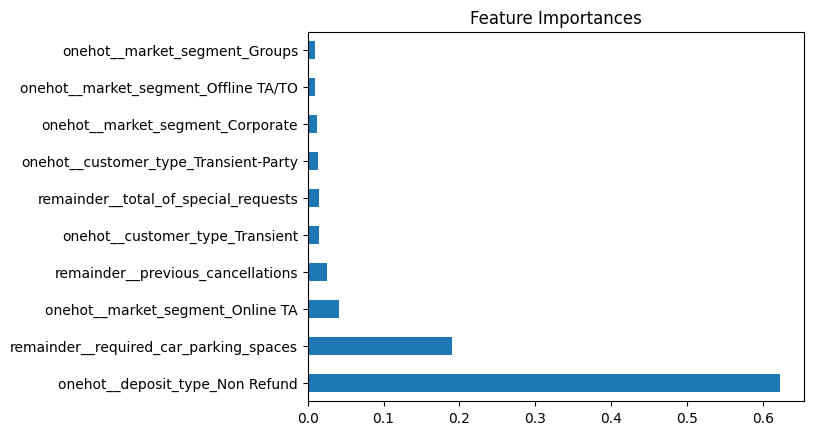

In [54]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

terlihat bahwa untuk model XGBoost fitur yang paling penting adalah Deposit type :non refund dan diikuti dengan required car parking space. kedua fitur tersebut trlihat pada saat analisis data bahwa memiliki persebaran data yang signifikan perbedaannya. kerena 99% dari 10111 data di non refund adalah data cancel. juga pada required car space ketika data diatas angka 0 maka dapat dipastikan booking akan dilanjutkan.

# Conclusion & Recommendation

In [55]:
print('Classification Report Default XGBoost : \n', report_default)

Classification Report Default XGBoost : 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     10559
           1       0.77      0.65      0.71      6156

    accuracy                           0.80     16715
   macro avg       0.79      0.77      0.78     16715
weighted avg       0.80      0.80      0.80     16715



Berdasarkan hasil classification report dari model default XBoost, dapat di simpulkan ketika model digunakan maka dapat menyaring para customer dengan 89% customer yang akan tetap menginap dan 65% customer yang akan membatalkan bookingnya jika dilihat dari recallnya.

model ini memiliki ketepatan sebesar 77 %(precicison) mengetahui customer yang membatalkan bookingnya dari 65% (recall) yang akan membatalkan bookingnya. dan akan tersisa 11% (recall) customer yang sebenarnya akan mencancel masih masuk kedalam list customer yang akan melanjutkan bookingannya.

bila seandainya biaya perkamar itu 840.000 rupiah (berdasarkan : https://www.agoda.com/en-gb/search?city=5590&checkIn=2023-03-15&los=1&rooms=1&adults=2&children=0&locale=en-gb&ckuid=a457af23-c14e-45f2-87b4-294dbd77605a&prid=0&gclid=Cj0KCQiA6LyfBhC3ARIsAG4gkF_QPB1m1oqPbNX91g8-qjrFcEUlbUysa9Cw7NTC6uhllc4qDsnehHMaAoq7EALw_wcB&currency=IDR&correlationId=073b3ded-9aff-4a00-9189-3c48642fb777&analyticsSessionId=8902887725591333422&pageTypeId=5&realLanguageId=16&languageId=1&origin=ID&cid=1891439&tag=a1504c41-b3fb-4c0d-ac56-2b0742e2bc0e&userId=a457af23-c14e-45f2-87b4-294dbd77605a&whitelabelid=1&loginLvl=0&storefrontId=3&currencyId=25&currencyCode=IDR&htmlLanguage=en-gb&cultureInfoName=en-gb&machineName=sg-geoweb-6003&trafficGroupId=5&sessionId=raouenigsefypygv5dq3knax&trafficSubGroupId=9&aid=82361&useFullPageLogin=true&cttp=4&isRealUser=true&mode=production&browserFamily=Chrome&checkOut=2023-03-16&priceCur=IDR&textToSearch=Albufeira&productType=-1&travellerType=1&familyMode=off), dan apa bila ada 200 booking yang masuk (100 orang cancel dan 100 orang tetap melakukan booking) maka hitungannya akan seperti ini :

Tanpa model :
- gross profit 1 kamar = Rp 840.000 x 200 orang => 168.000.000/hari
- total customer cancel 100 orang = - Rp 84.000.000
- total customer booking 100 orang = Rp 84.000.000
- selisih untung rugi hotel adalah = 84.000.000 (100booking) - 84.000.000 (100cancel) = Rp 0,00-

dengan model :
- 65 orang (dari 100 orang cancel) x Rp. 840.000 = 54.600.000 (berdasarkan nilai recall cancel) TP
- 11 orang (dari 100 orang cancel) x Rp. 840.000 =  9.240.000 (berdasarkan recall tetap booking) FP
- 54.600.000 + 9.240.000 =Rp 63.840.000

- 35 orang (dari 100orang cancel tetap booking) x Rp.840.000 = 29.400.000 ( berdasarkan recall cancel) FN
- 89 orang (dari 100 orang tetap booking) x Rp. 840.000 = 74.760.000 ( berdasarkan recall tetap booking) TN
- selisih untung-rugi yang dialami setelah menggunakan model =Rp. 104.160.000 - Rp. 63.840.000 = Rp 40.320.000

dengan menggunakan model saya hotel dapat memprediksi pemasukannya di hari tersebut. 



# Recommendation

Hal Hal yang bisa dilakukan agar bisa menjukan model lebih baik lagi :
- Fitur fitur dari data dapat di tambahkan lagi seperti jasa jasa yang hotel berikan agar dapat lebih terlihat jasa apa yang menjadi deal breaker. Seperti satisfaction level terhadap jasa jasa yang diberikan.
- Menggunakan evaluation metric lain seperti focus untuk recall saja agar meminimalisir false negativenya bisa dilihat di data saya bahwa `KNN` memiliki nilai Recall terbesar. 
- gunakan hyperparameter lain agar hasilnya bisa lebih meningkat ataupun menggunakan Teknik oversampling lain selain randomeoversampler.
- gunakan model lain seperit LGBM , Random forest, jika masih menggunakan ROC AUC sebagai metric nya. karena nilainya tidak terpaut jauh.




In [57]:
import pickle

with open('estimator_model.pickle', 'wb') as f:
    pickle.dump(estimator, f)


with open('C:/Users/Dlos/Documents/PURWADHIKA/Capstone 3/model.pkl', 'wb') as f:
    pickle.dump(estimator, f)
